In [240]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob
import os
import requests
import warnings
from matplotlib.colors import Normalize
import cv2 as cv

warnings.filterwarnings('ignore')

# Global constants
DATA_PATH = '../data/'
OUTPUT_PATH = '../output/'
DX = 5.106500953873407  # Spatial resolution [m]
DT = 0.0016             # Temporal resolution [s]
FS = 625                # Sampling frequency [Hz]

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [241]:

def check_data_exists(data_path=DATA_PATH):
    """Check if .npy files exist in data directory"""
    if not os.path.exists(data_path):
        return False
    npy_files = glob.glob(os.path.join(data_path, '*.npy'))
    return len(npy_files) > 0

In [242]:
def download_data(data_path=DATA_PATH):
    """Download and extract DAS data from Google Drive if not already present."""
    # Create data directory
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # Check if already exists
    if check_data_exists(data_path):
        npy_files = glob.glob(os.path.join(data_path, '*.npy'))
        print(f"✓ Data already exists! Found {len(npy_files)} .npy files")
        return True

    print("\n" + "="*70)
    print(" DOWNLOADING DAS DATA")
    print("="*70)

    # Download URL
    url = "https://drive.usercontent.google.com/download?id=1lJKLz3LsQmnAf9q5GGi6arEYBz-3CMhx&export=download&authuser=0&confirm=t"
    archive_path = os.path.join(data_path, "data.rar")

    # Download file
    print("\nDownloading data...")
    try:
        response = requests.get(url, stream=True, allow_redirects=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(archive_path, 'wb') as f:
            if total_size == 0:
                f.write(response.content)
            else:
                downloaded = 0
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    downloaded += len(chunk)
                    progress = (downloaded / total_size) * 100
                    print(f"\rProgress: {progress:.1f}%", end='')

        print(f"\n✓ Downloaded: {os.path.getsize(archive_path) / (1024*1024):.1f} MB")

    except Exception as e:
        print(f"\n✗ Download failed: {e}")
        return False

    # Extract RAR file (requires patool)
    print("\nExtracting archive...")
    try:
        import patoolib
        patoolib.extract_archive(archive_path, outdir=data_path)
        print("✓ Extraction complete!")
        os.remove(archive_path)
        print("✓ Cleaned up archive file")
    except ImportError:
        print("⚠ patoolib not installed. Please install: pip install patool")
        print(f"  Manual extraction needed: {archive_path}")
        return False
    except Exception as e:
        print(f"✗ Extraction failed: {e}")
        return False

    npy_files = glob.glob(os.path.join(data_path, '*.npy'))
    print("\n" + "="*70)
    print(f"✓ SUCCESS! Found {len(npy_files)} .npy files")
    print("="*70 + "\n")

    return len(npy_files) > 0

In [243]:
download_data()

✓ Data already exists! Found 259 .npy files


True

In [244]:
def load_das_segment(start_time, end_time, data_path=DATA_PATH, 
                     dx=DX, dt=DT, verbose=True):
    """Load DAS data for a specific time segment."""
    # Get all available files
    all_files = glob.glob(os.path.join(data_path, '*.npy'))
    all_files.sort()

    if len(all_files) == 0:
        raise ValueError(f"No .npy files found in {data_path}")

    # Filter files in time range
    files_to_load = []
    for fpath in all_files:
        fname = os.path.basename(fpath).replace('.npy', '')
        if start_time <= fname <= end_time:
            files_to_load.append(fpath)

    if len(files_to_load) == 0:
        raise ValueError(f"No files found between {start_time} and {end_time}")

    # Load and stack all files
    data_list = []
    for fpath in files_to_load:
        fname = os.path.basename(fpath)
        try:
            data_chunk = np.load(fpath)
            data_list.append(data_chunk)
            if verbose:
                print(f"✓ {fname} - Shape: {data_chunk.shape}")
        except Exception as e:
            if verbose:
                print(f"✗ {fname} - Error: {e}")

    # Stack vertically (concatenate in time)
    data = np.vstack(data_list)

    if verbose:
        print("\n" + "="*60)
        print("LOADING COMPLETE")
        print("="*60)
        print(f"Files loaded: {len(files_to_load)}")
        print(f"Data shape: {data.shape}")
        print(f"Duration: {data.shape[0] * dt:.2f} seconds")
        print(f"Spatial extent: {data.shape[1] * dx:.1f} meters")
        print("="*60 + "\n")

    # Create DataFrame with time and position labels
    time_start = datetime.datetime.strptime(f'20240507 {start_time}', '%Y%m%d %H%M%S')
    time_index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')
    spatial_columns = np.arange(data.shape[1]) * dx

    df = pd.DataFrame(data=data, index=time_index, columns=spatial_columns)

    return df

In [245]:
df_raw = load_das_segment(start_time='090522', end_time='090712')


✓ 090522.npy - Shape: (6250, 52)
✓ 090532.npy - Shape: (6250, 52)
✓ 090542.npy - Shape: (6250, 52)
✓ 090552.npy - Shape: (6250, 52)
✓ 090602.npy - Shape: (6250, 52)
✓ 090612.npy - Shape: (6250, 52)
✓ 090622.npy - Shape: (6250, 52)
✓ 090632.npy - Shape: (6250, 52)
✓ 090642.npy - Shape: (6250, 52)
✓ 090652.npy - Shape: (6250, 52)
✓ 090702.npy - Shape: (6250, 52)
✓ 090712.npy - Shape: (6250, 52)

LOADING COMPLETE
Files loaded: 12
Data shape: (75000, 52)
Duration: 120.00 seconds
Spatial extent: 265.5 meters



In [246]:
def set_axis(x, no_labels=7):
    """Sets the x-axis positions and labels for a plot."""
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0, nx, step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

In [267]:
def visualize_das(df, title="DAS Data", figsize=(12, 16), save_path=None, normalize=True):
    """Visualize DAS data with proper scaling and labels."""
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    # Preprocessing: center and take absolute value
    
    if normalize:
        df_display = df.copy()
        # Normalize to percentiles for better visualization
        low, high = np.percentile(df_display, [3, 99]) 
        norm = Normalize(vmin=low, vmax=high, clip=True)
        im = ax.imshow(df_display, interpolation='none', aspect='auto', norm=norm)
    else:
        im = ax.imshow(df, interpolation='none', aspect='auto')
    plt.ylabel('Time')
    plt.xlabel('Space [m]')
    plt.title(title)
    
    # Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 
                        0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    
    # Set axis ticks
    x_positions, x_labels = set_axis(df.columns.values)
    ax.set_xticks(x_positions, np.round(x_labels))
    
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

In [ ]:
df_display = df_raw.copy()
df_display -= df_display.mean()
df_abs = np.abs(df_display)

Saved: ../output/raw_data_absolute.png


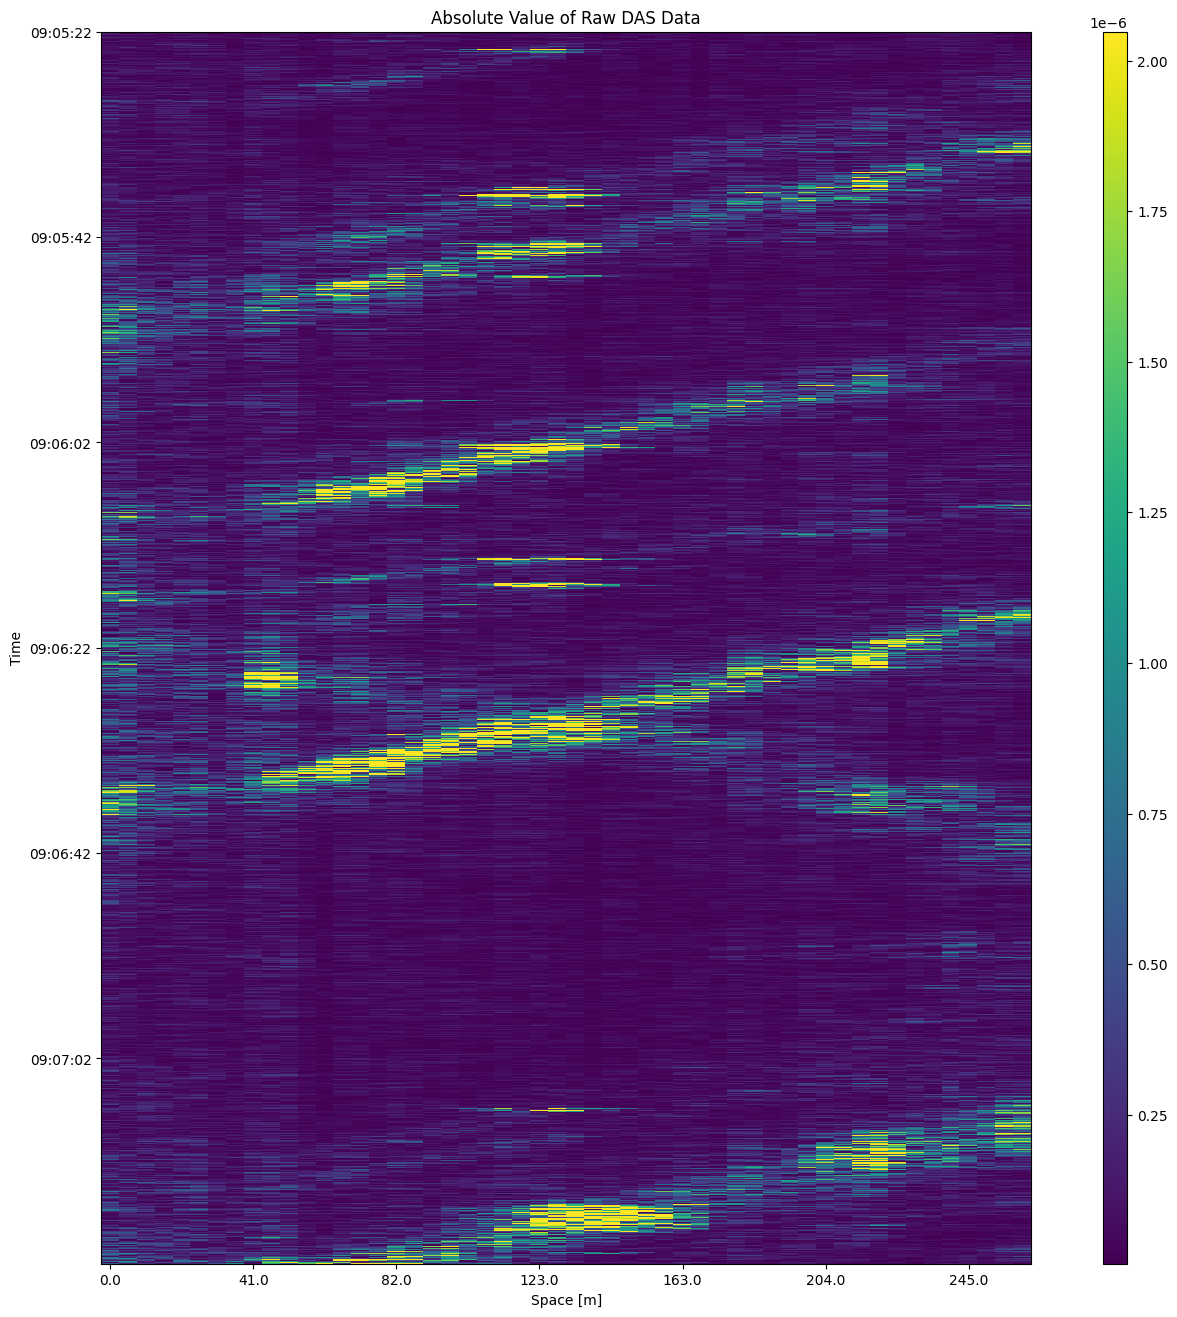

In [271]:
visualize_das(df_abs, title="Absolute Value of Raw DAS Data", 
              save_path=os.path.join(OUTPUT_PATH, 'raw_data_absolute.png'), normalize=True)

In [250]:
def analyze_statistics(df):
    """Compute basic statistics and visualize key metrics."""
    data_flat = df.values.flatten()
    
    # Calculate key metrics
    stats = {
        'mean': np.mean(data_flat),
        'std': np.std(data_flat),
        'min': np.min(data_flat),
        'max': np.max(data_flat),
        'median': np.median(data_flat),
        'p95': np.percentile(data_flat, 95),
        'p99': np.percentile(data_flat, 99)
    }
    
    print("="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)
    for key, val in stats.items():
        print(f"{key:10s}: {val:.6e}")
    print("="*60)
    
    # Per-channel variance (noise detection)
    channel_vars = df.var(axis=0).values
    
    # Total energy over time (event detection)
    time_energy = (df ** 2).sum(axis=1).values
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Variance per channel
    axes[0].plot(df.columns.values, channel_vars, 'r-', linewidth=1.5)
    axes[0].set_xlabel('Position [m]')
    axes[0].set_ylabel('Variance')
    axes[0].set_title('Temporal Variance per Channel')
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Energy over time
    time_axis = np.arange(len(time_energy)) * DT
    axes[1].plot(time_axis, time_energy, 'purple', linewidth=0.8)
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('Total Energy')
    axes[1].set_title('Total Energy Over Time')
    axes[1].grid(alpha=0.3)
    
    # Mark high-energy events
    threshold = stats['p99'] ** 2 * df.shape[1]
    events = time_energy > threshold
    axes[1].scatter(time_axis[events], time_energy[events], 
                    c='red', s=15, alpha=0.6, label='High-energy events')
    axes[1].axhline(y=threshold, color='red', linestyle='--', 
                    alpha=0.5, label='Threshold')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'statistics.png'), dpi=300)
    plt.show()
    
    return stats



STATISTICAL ANALYSIS
mean      : -6.268834e-11
std       : 5.668068e-07
min       : -7.182795e-05
max       : 6.143754e-05
median    : 0.000000e+00
p95       : 4.286515e-07
p99       : 1.351129e-06


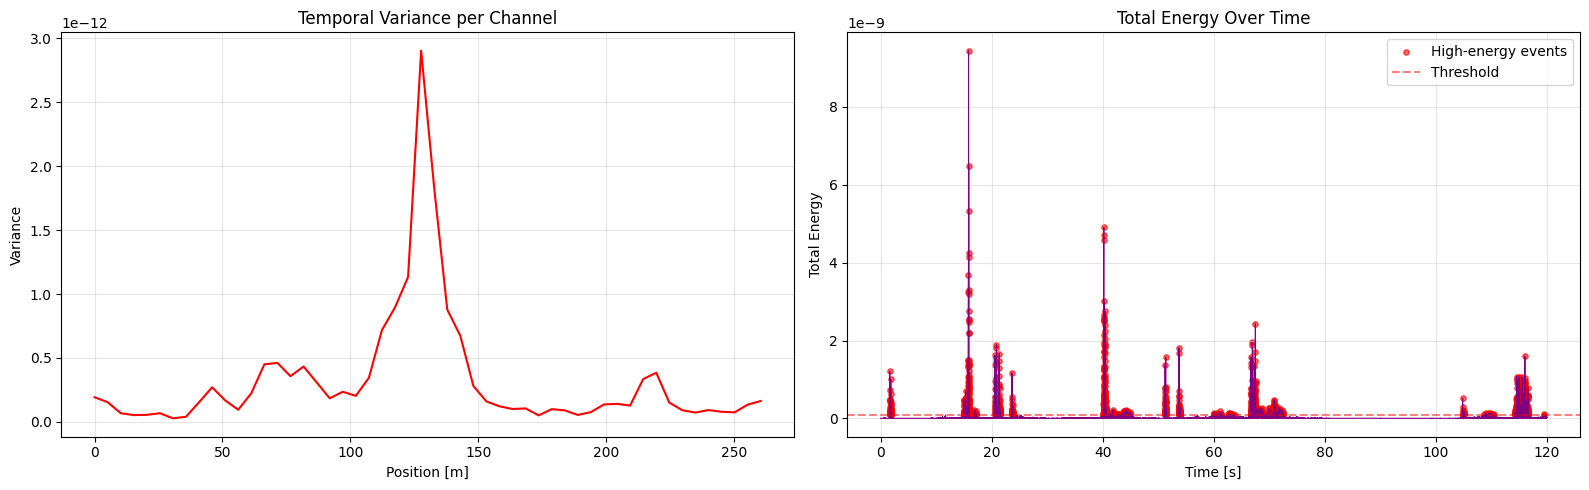

In [251]:
stats = analyze_statistics(df_raw)


FREQUENCY CONTENT ANALYSIS


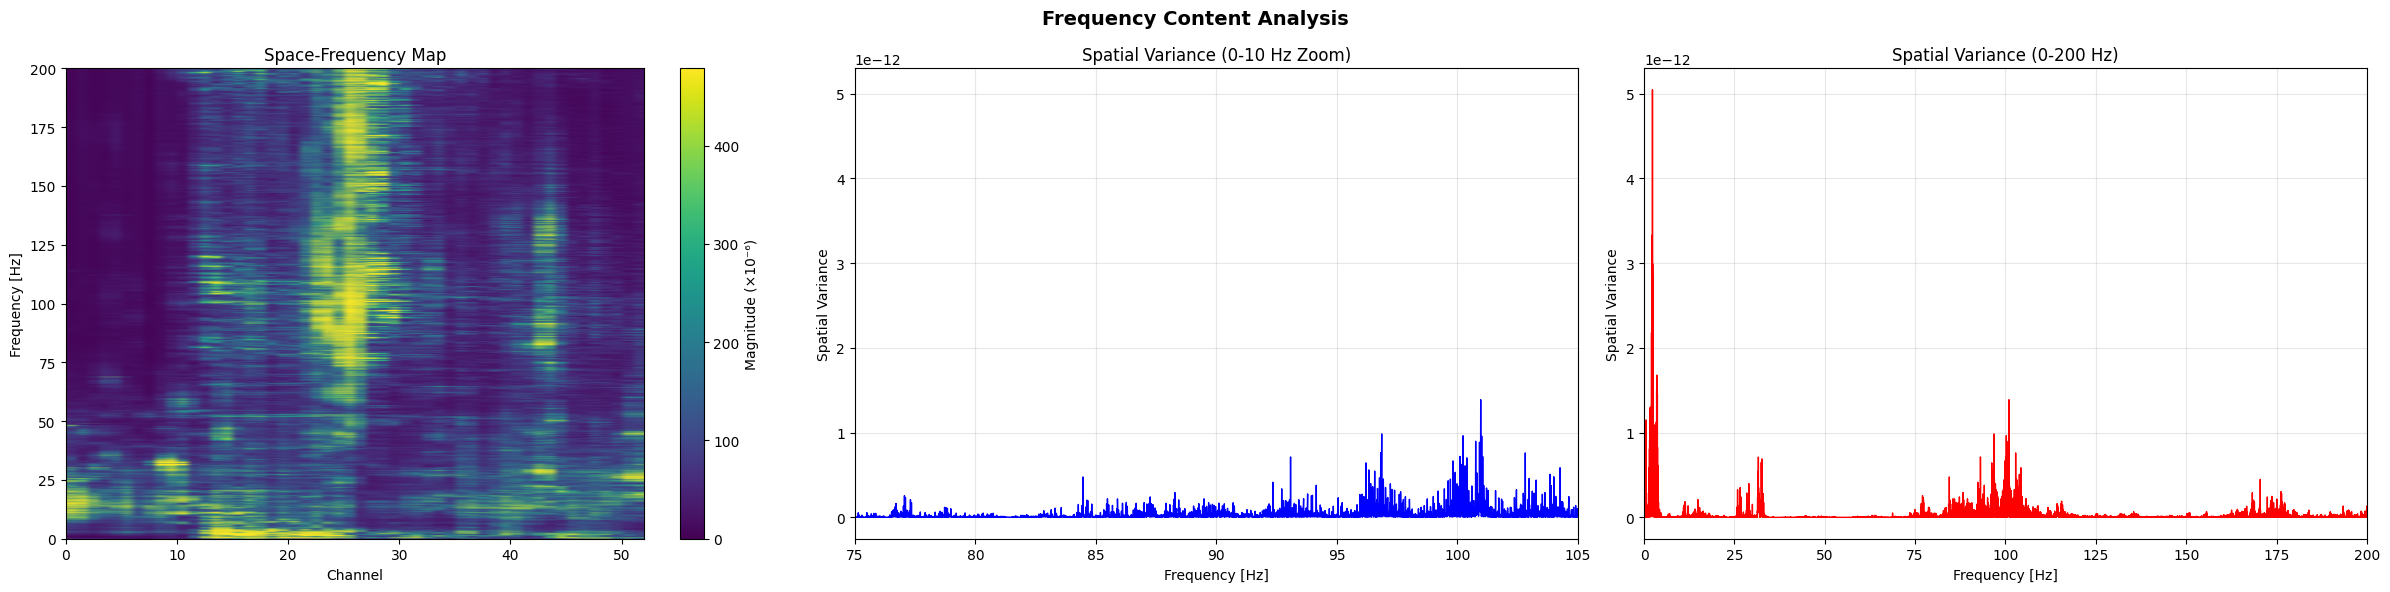

Maximum spatial variance at 2.3 Hz


In [252]:
def analyze_frequency_content(df, fs=FS):
    """Analyze frequency content using FFT."""
    print("\n" + "="*70)
    print("FREQUENCY CONTENT ANALYSIS")
    print("="*70)
    
    # Compute FFT
    fft_data = np.fft.rfft(df.values, axis=0)
    magnitude = np.abs(fft_data)
    power = magnitude ** 2
    freqs = np.fft.rfftfreq(df.shape[0], d=1/fs)
    power_variance = np.var(power, axis=1)
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle('Frequency Content Analysis', fontsize=14, fontweight='bold')
    
    # Plot 1: Space-Frequency Map
    magnitude_scaled = magnitude * 1e6
    magnitude_scaled[0, :] = 0  # Remove DC
    v_max = np.percentile(magnitude_scaled, 98)
    
    extent = [0, df.shape[1], 0, fs/2]
    im = axes[0].imshow(magnitude_scaled, aspect='auto', origin='lower', 
                        cmap='viridis', extent=extent, vmax=v_max, vmin=0)
    plt.colorbar(im, ax=axes[0], label='Magnitude (×10⁻⁶)')
    axes[0].set_ylim([0, 200])
    axes[0].set_xlabel('Channel')
    axes[0].set_ylabel('Frequency [Hz]')
    axes[0].set_title('Space-Frequency Map')
    
    # Plot 2: Spatial Variance (0-5 Hz)
    axes[1].plot(freqs, power_variance, 'b-', linewidth=1.0)
    axes[1].set_xlabel('Frequency [Hz]')
    axes[1].set_ylabel('Spatial Variance')
    axes[1].set_title('Spatial Variance (0-10 Hz Zoom)')
    axes[1].grid(alpha=0.3)
    axes[1].set_xlim([75, 105])
    
    # Plot 3: Spatial Variance (Full Scale)
    axes[2].plot(freqs, power_variance, 'r-', linewidth=1.0)
    axes[2].set_xlabel('Frequency [Hz]')
    axes[2].set_ylabel('Spatial Variance')
    axes[2].set_title('Spatial Variance (0-200 Hz)')
    axes[2].grid(alpha=0.3)
    axes[2].set_xlim([0, 200])
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'frequency_analysis.png'), dpi=300)
    plt.show()
    
    max_variance_freq = freqs[1:][np.argmax(power_variance[1:])]
    print(f"Maximum spatial variance at {max_variance_freq:.1f} Hz")
    
    return freqs, power_variance


freqs, power_var = analyze_frequency_content(df_raw)

In [253]:
def apply_bandpass_filter(df, lowcut=1.5, highcut=3.0, fs=FS):
    """Apply bandpass filter using FFT."""
    print(f"\nApplying Bandpass Filter: {lowcut}-{highcut} Hz")
    
    data = df.values
    n_samples = data.shape[0]
    dt = 1.0 / fs
    
    # Compute FFT
    fft_coeffs = np.fft.rfft(data, axis=0)
    freqs = np.fft.rfftfreq(n_samples, d=dt)
    
    # Create frequency mask
    mask = (freqs >= lowcut) & (freqs <= highcut)
    
    # Apply filter
    fft_filtered = fft_coeffs * mask[:, np.newaxis]
    
    # Inverse FFT
    data_filtered = np.fft.irfft(fft_filtered, n=n_samples, axis=0)
    
    df_filtered = pd.DataFrame(data_filtered, index=df.index, columns=df.columns)
    
    print(f"✓ Filter applied successfully")
    return df_filtered



NARROW BANDPASS FILTER: 25.5-27.5 Hz

Applying Bandpass Filter: 25.5-27.5 Hz
✓ Filter applied successfully
ABSOLUTE VALUE (oscillation magnitude):

Absolute value range: [0, 2.09e-06]
Saved: ../output/filtered_abs_2-2.5Hz.png


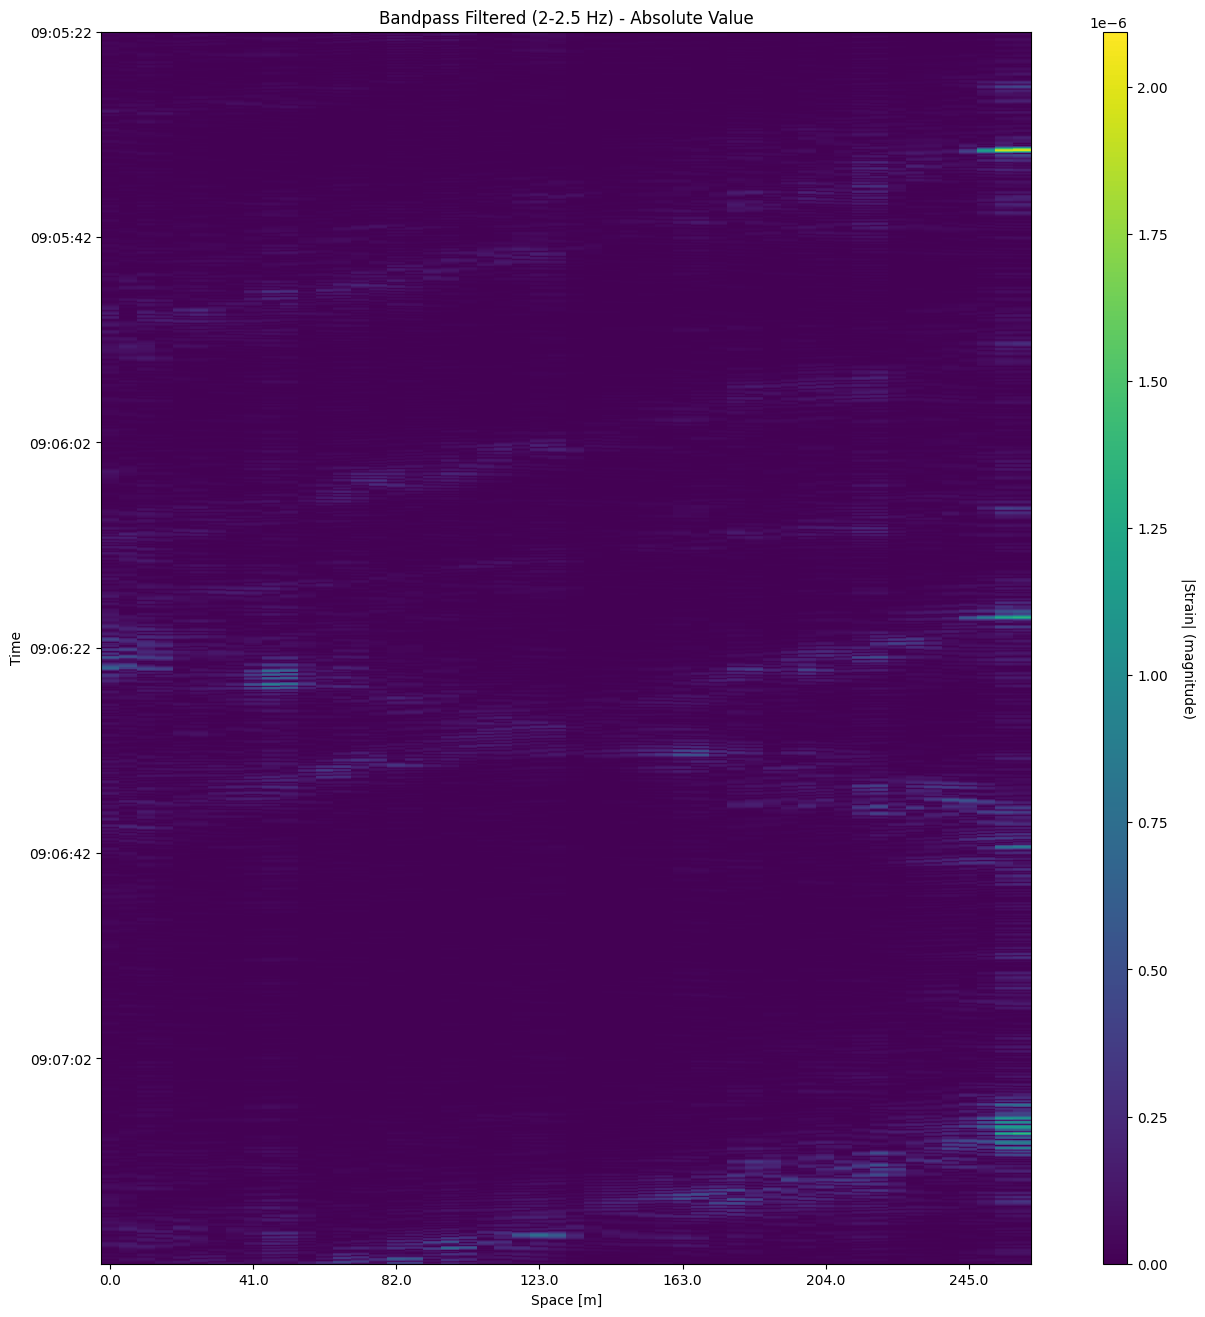

In [254]:
def visualize_filtered_absolute(df, title="Filtered Data (Absolute)", 
                                figsize=(12, 16), save_path=None):
    """
    Visualize ABSOLUTE VALUE of filtered data.
    Shows the envelope/magnitude of oscillations.
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    # Take absolute value to show magnitude
    data = np.abs(df.values)
    
    # Use full range without clipping
    vmin = 0
    vmax = data.max()
    
    print(f"\nAbsolute value range: [0, {vmax:.2e}]")
    
    # Use sequential colormap
    im = ax.imshow(data, interpolation='none', aspect='auto', 
                   cmap='viridis', vmin=vmin, vmax=vmax)
    
    plt.ylabel('Time')
    plt.xlabel('Space [m]')
    plt.title(title)
    
    # Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 
                        0.02, ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('|Strain| (magnitude)', rotation=270, labelpad=20)
    
    # Set axis ticks
    x_positions, x_labels = set_axis(df.columns.values)
    ax.set_xticks(x_positions, np.round(x_labels))
    
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


# Apply narrow bandpass filter (25.5-27.5 Hz)
print("\n" + "="*70)
print("NARROW BANDPASS FILTER: 25.5-27.5 Hz")
print("="*70)
df_fft = apply_bandpass_filter(df_raw, lowcut=25.5, highcut=27.5)


# Visualize ABSOLUTE VALUE (magnitude envelope)
print("ABSOLUTE VALUE (oscillation magnitude):")
visualize_filtered_absolute(df_fft, 
                            title="Bandpass Filtered (2-2.5 Hz) - Absolute Value", 
                            save_path=os.path.join(OUTPUT_PATH, 'filtered_abs_2-2.5Hz.png'))


In [255]:
def compare_filters(df, fs=FS):
    """Compare different bandpass filter configurations."""
    
    filters = [
        (0.4, 0.8, 'Very Narrow (0.4-0.8 Hz)'),
        (1.5, 3, 'Narrow (1.5-3 Hz)'),
        (2,2.5, 'Medium (2-2.5 Hz)'),
        (0, 5, 'Wide (0-5 Hz)'),
        (25, 35, 'Very Narrow (25-35 Hz)'),
        (31, 33, 'Narrow (31-33 Hz)'),
        (25.5,27.5, 'Medium (25.5-27.5 Hz)'),
        (95, 98, 'Wide (95-98 Hz)'),
        (98, 102, 'Very Narrow (98-102 Hz)')]
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    axes = axes.flatten()
    
    
    for idx, (low, high, label) in enumerate(filters):
        df_filt = apply_bandpass_filter(df, lowcut=low, highcut=high, fs=fs)

        # Take absolute value for comparison
        data = np.abs(df_filt.values)
        vmax = data.max()
        
        ax = axes[idx]
        im = ax.imshow(data, interpolation='none', aspect='auto',
                      cmap='viridis', vmin=0, vmax=vmax)
        ax.set_title(f"{label}\n{low}-{high} Hz | Max: {vmax:.2e}", 
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('Time')
        ax.set_xlabel('Space [m]')
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_PATH, 'filter_comparison.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved comparison: {save_path}")
    plt.show()



In [256]:
def compare_filters_preprocessed(df, fs=FS, use_percentile=False):
    """Compare different bandpass filters using original preprocessing."""
    
    filters = [
        (0.4, 0.8, 'Very Low (0.4-0.8 Hz)'),
        (1.5, 3, 'Low (1.5-3 Hz)'),
        (2, 2.5, 'Low-Narrow (2-2.5 Hz)'),
        (0, 5, 'Low-Wide (0-5 Hz)'),
        (25, 35, 'Mid (25-35 Hz)'),
        (31, 33, 'Mid-Narrow (31-33 Hz)'),
        (25.5, 27.5, 'Mid-Medium (25.5-27.5 Hz)'),
        (95, 98, 'High (95-98 Hz)'),
        (98, 102, 'High-Narrow (98-102 Hz)')
    ]
    
    fig, axes = plt.subplots(3, 3, figsize=(24, 24))
    axes = axes.flatten()
    
    norm_type = "PERCENTILE (3-99%)" if use_percentile else "FULL RANGE"
    print("\n" + "="*70)
    print(f"COMPARING FILTERS - PREPROCESSED ({norm_type})")
    print("="*70)
    
    for idx, (low, high, label) in enumerate(filters):
        df_filt = apply_bandpass_filter(df, lowcut=low, highcut=high, fs=fs)
        
        # Apply original preprocessing: center and absolute value
        df_display = df_filt.copy()
        df_display -= df_display.mean()
        df_display = np.abs(df_display)
        
        # Choose normalization
        if use_percentile:
            vmin, vmax = np.percentile(df_display, [3, 99])
            norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
        else:
            vmin = df_display.min().min()
            vmax = df_display.max().max()
            norm = Normalize(vmin=vmin, vmax=vmax, clip=False)
        
        ax = axes[idx]
        im = ax.imshow(df_display.values, interpolation='none', aspect='auto',
                      cmap='viridis', norm=norm)
        ax.set_title(f"{label}\n{low}-{high} Hz | Range: [{vmin:.2e}, {vmax:.2e}]", 
                    fontsize=11, fontweight='bold')
        ax.set_ylabel('Time', fontsize=9)
        ax.set_xlabel('Space [m]', fontsize=9)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        print(f"{label:25s}: Range [{vmin:.2e}, {vmax:.2e}]")
    
    plt.tight_layout()
    suffix = 'percentile' if use_percentile else 'fullrange'
    save_path = os.path.join(OUTPUT_PATH, f'filter_comparison_preprocessed_{suffix}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved comparison: {save_path}")
    plt.show()


VERSION 1: Full Range Normalization

COMPARING FILTERS - PREPROCESSED (FULL RANGE)

Applying Bandpass Filter: 0.4-0.8 Hz
✓ Filter applied successfully
Very Low (0.4-0.8 Hz)    : Range [1.41e-15, 1.10e-06]

Applying Bandpass Filter: 1.5-3 Hz
✓ Filter applied successfully
Low (1.5-3 Hz)           : Range [1.40e-14, 4.36e-06]

Applying Bandpass Filter: 2-2.5 Hz
✓ Filter applied successfully
Low-Narrow (2-2.5 Hz)    : Range [3.13e-15, 2.23e-06]

Applying Bandpass Filter: 0-5 Hz
✓ Filter applied successfully
Low-Wide (0-5 Hz)        : Range [5.40e-15, 6.59e-06]

Applying Bandpass Filter: 25-35 Hz
✓ Filter applied successfully
Mid (25-35 Hz)           : Range [4.66e-15, 8.35e-06]

Applying Bandpass Filter: 31-33 Hz
✓ Filter applied successfully
Mid-Narrow (31-33 Hz)    : Range [1.73e-15, 5.06e-06]

Applying Bandpass Filter: 25.5-27.5 Hz
✓ Filter applied successfully
Mid-Medium (25.5-27.5 Hz): Range [4.68e-15, 2.09e-06]

Applying Bandpass Filter: 95-98 Hz
✓ Filter applied successfully
High (

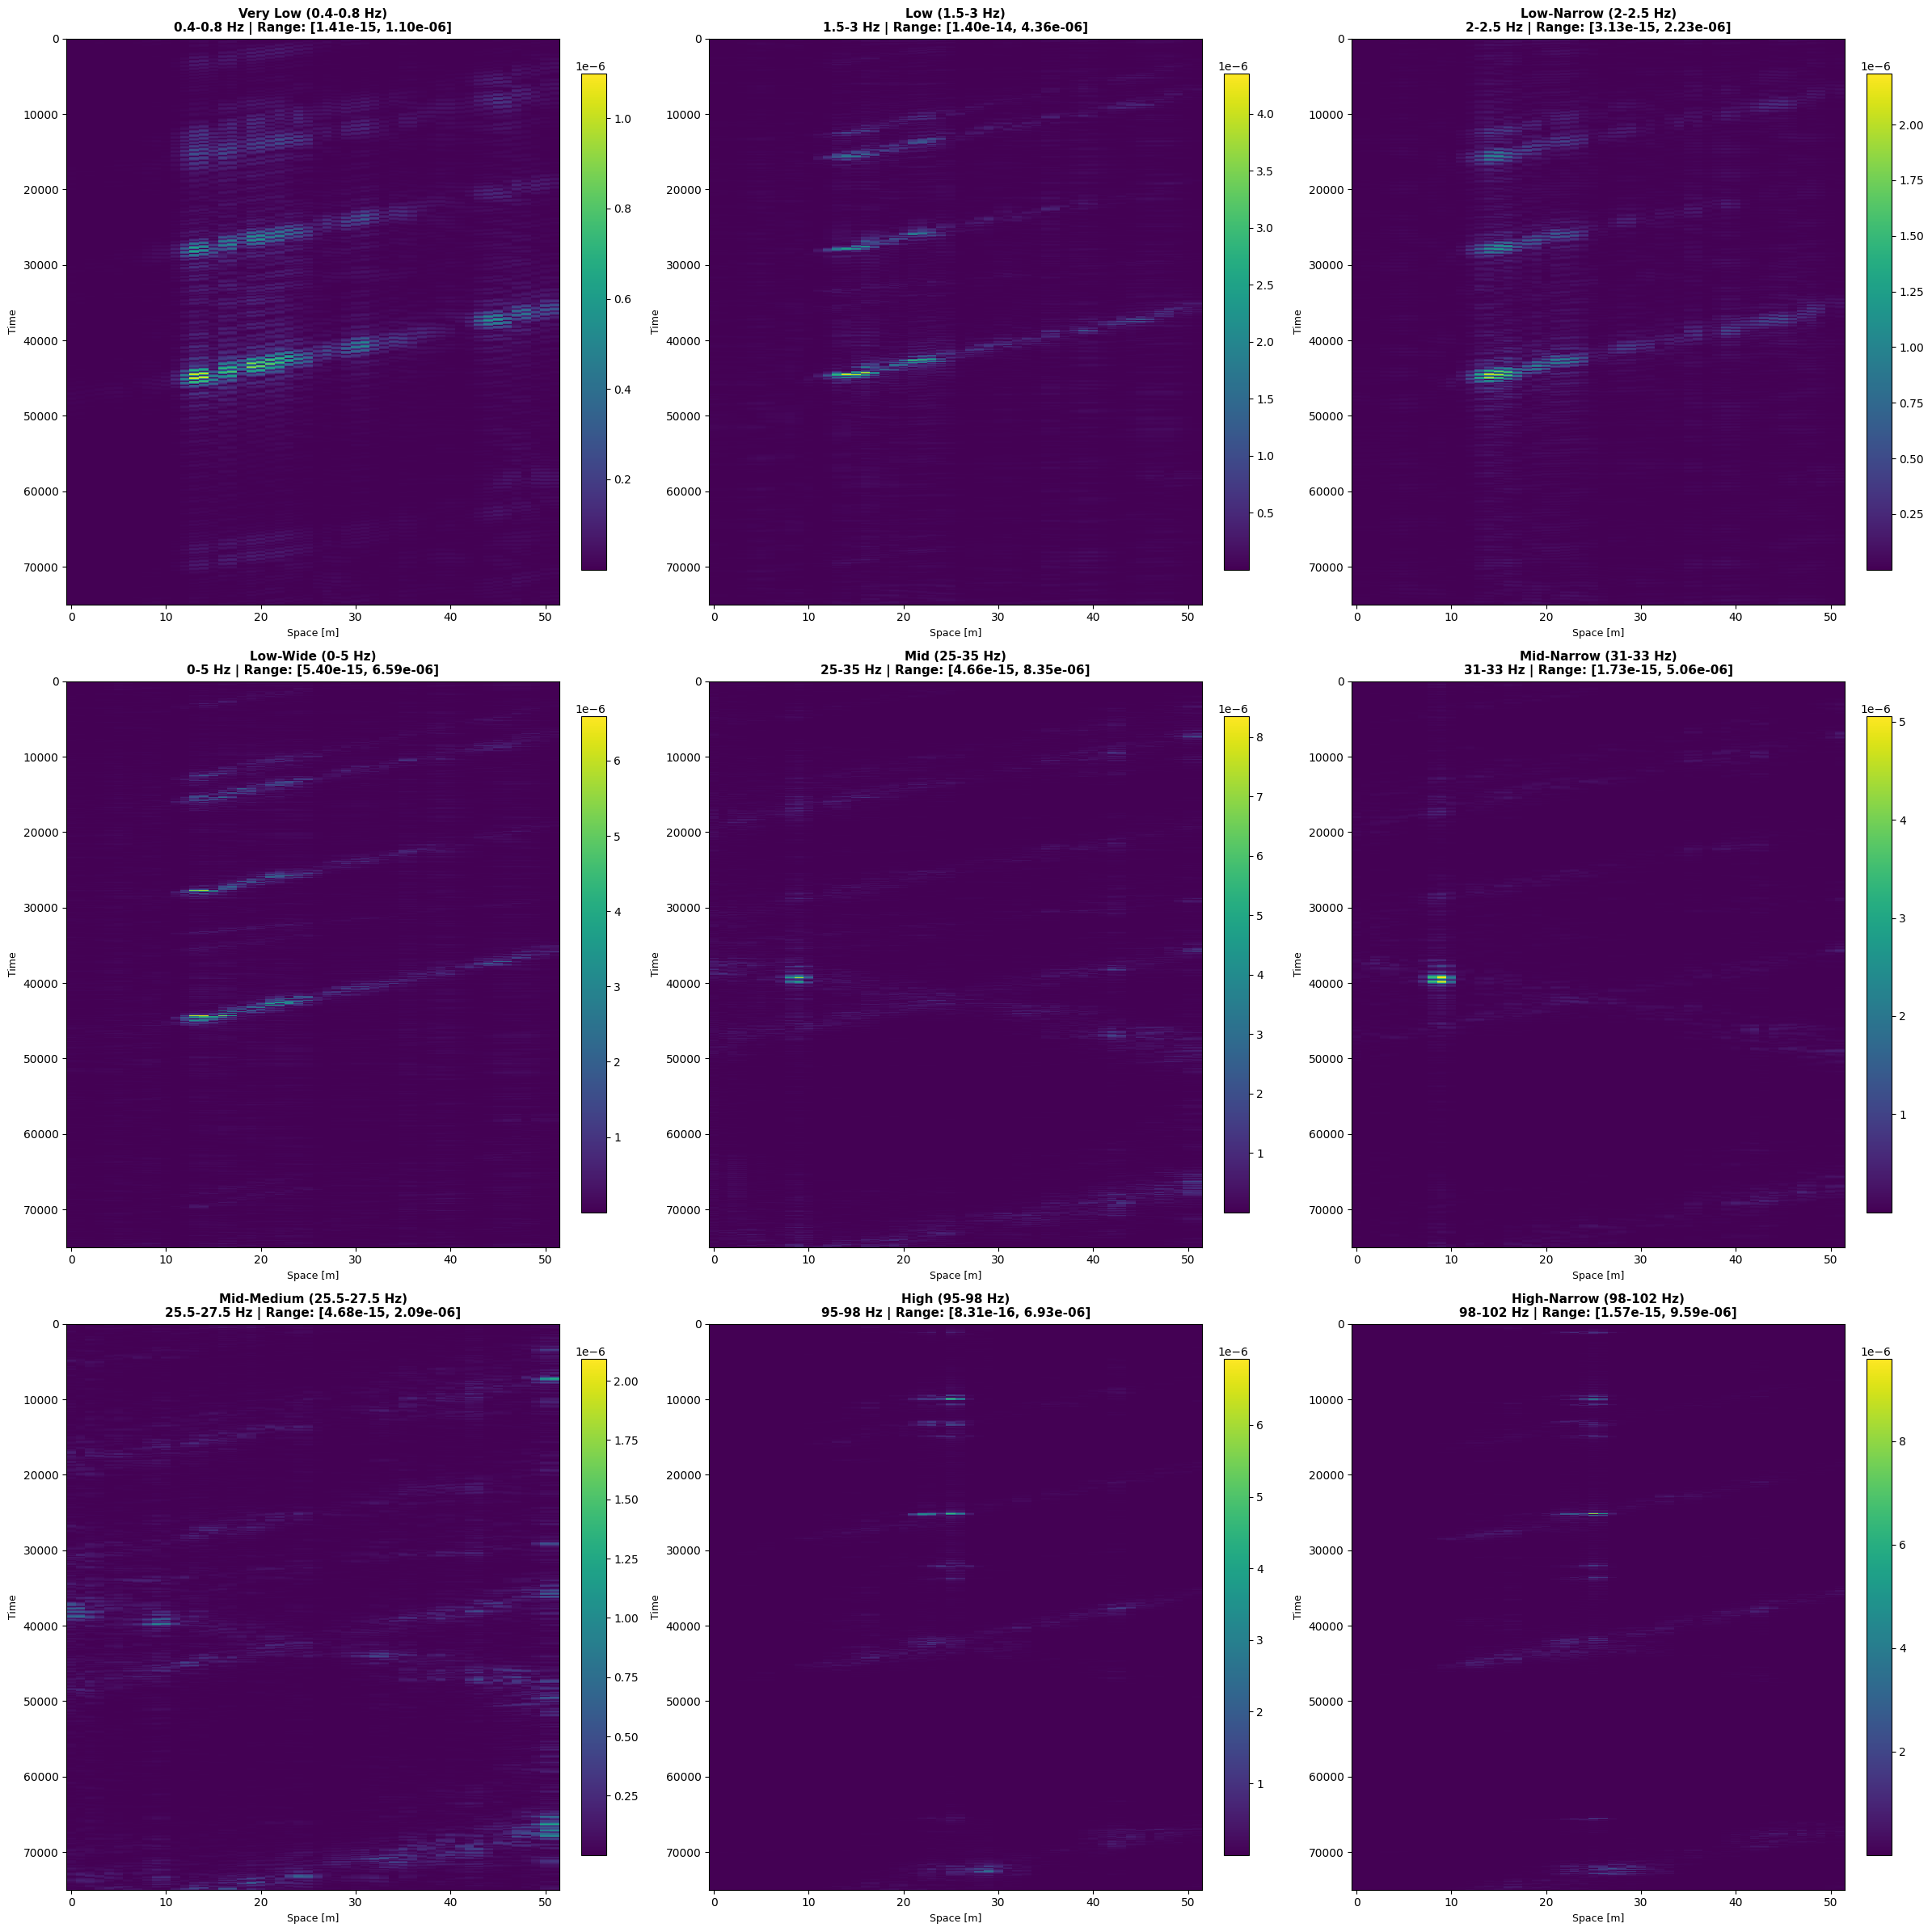


VERSION 2: Percentile Normalization (3-99%)

COMPARING FILTERS - PREPROCESSED (PERCENTILE (3-99%))

Applying Bandpass Filter: 0.4-0.8 Hz
✓ Filter applied successfully
Very Low (0.4-0.8 Hz)    : Range [1.84e-10, 2.73e-07]

Applying Bandpass Filter: 1.5-3 Hz
✓ Filter applied successfully
Low (1.5-3 Hz)           : Range [9.40e-10, 4.71e-07]

Applying Bandpass Filter: 2-2.5 Hz
✓ Filter applied successfully
Low-Narrow (2-2.5 Hz)    : Range [5.81e-10, 3.36e-07]

Applying Bandpass Filter: 0-5 Hz
✓ Filter applied successfully
Low-Wide (0-5 Hz)        : Range [1.36e-09, 6.43e-07]

Applying Bandpass Filter: 25-35 Hz
✓ Filter applied successfully
Mid (25-35 Hz)           : Range [7.46e-10, 5.19e-07]

Applying Bandpass Filter: 31-33 Hz
✓ Filter applied successfully
Mid-Narrow (31-33 Hz)    : Range [3.53e-10, 1.94e-07]

Applying Bandpass Filter: 25.5-27.5 Hz
✓ Filter applied successfully
Mid-Medium (25.5-27.5 Hz): Range [4.62e-10, 2.58e-07]

Applying Bandpass Filter: 95-98 Hz
✓ Filter applied suc

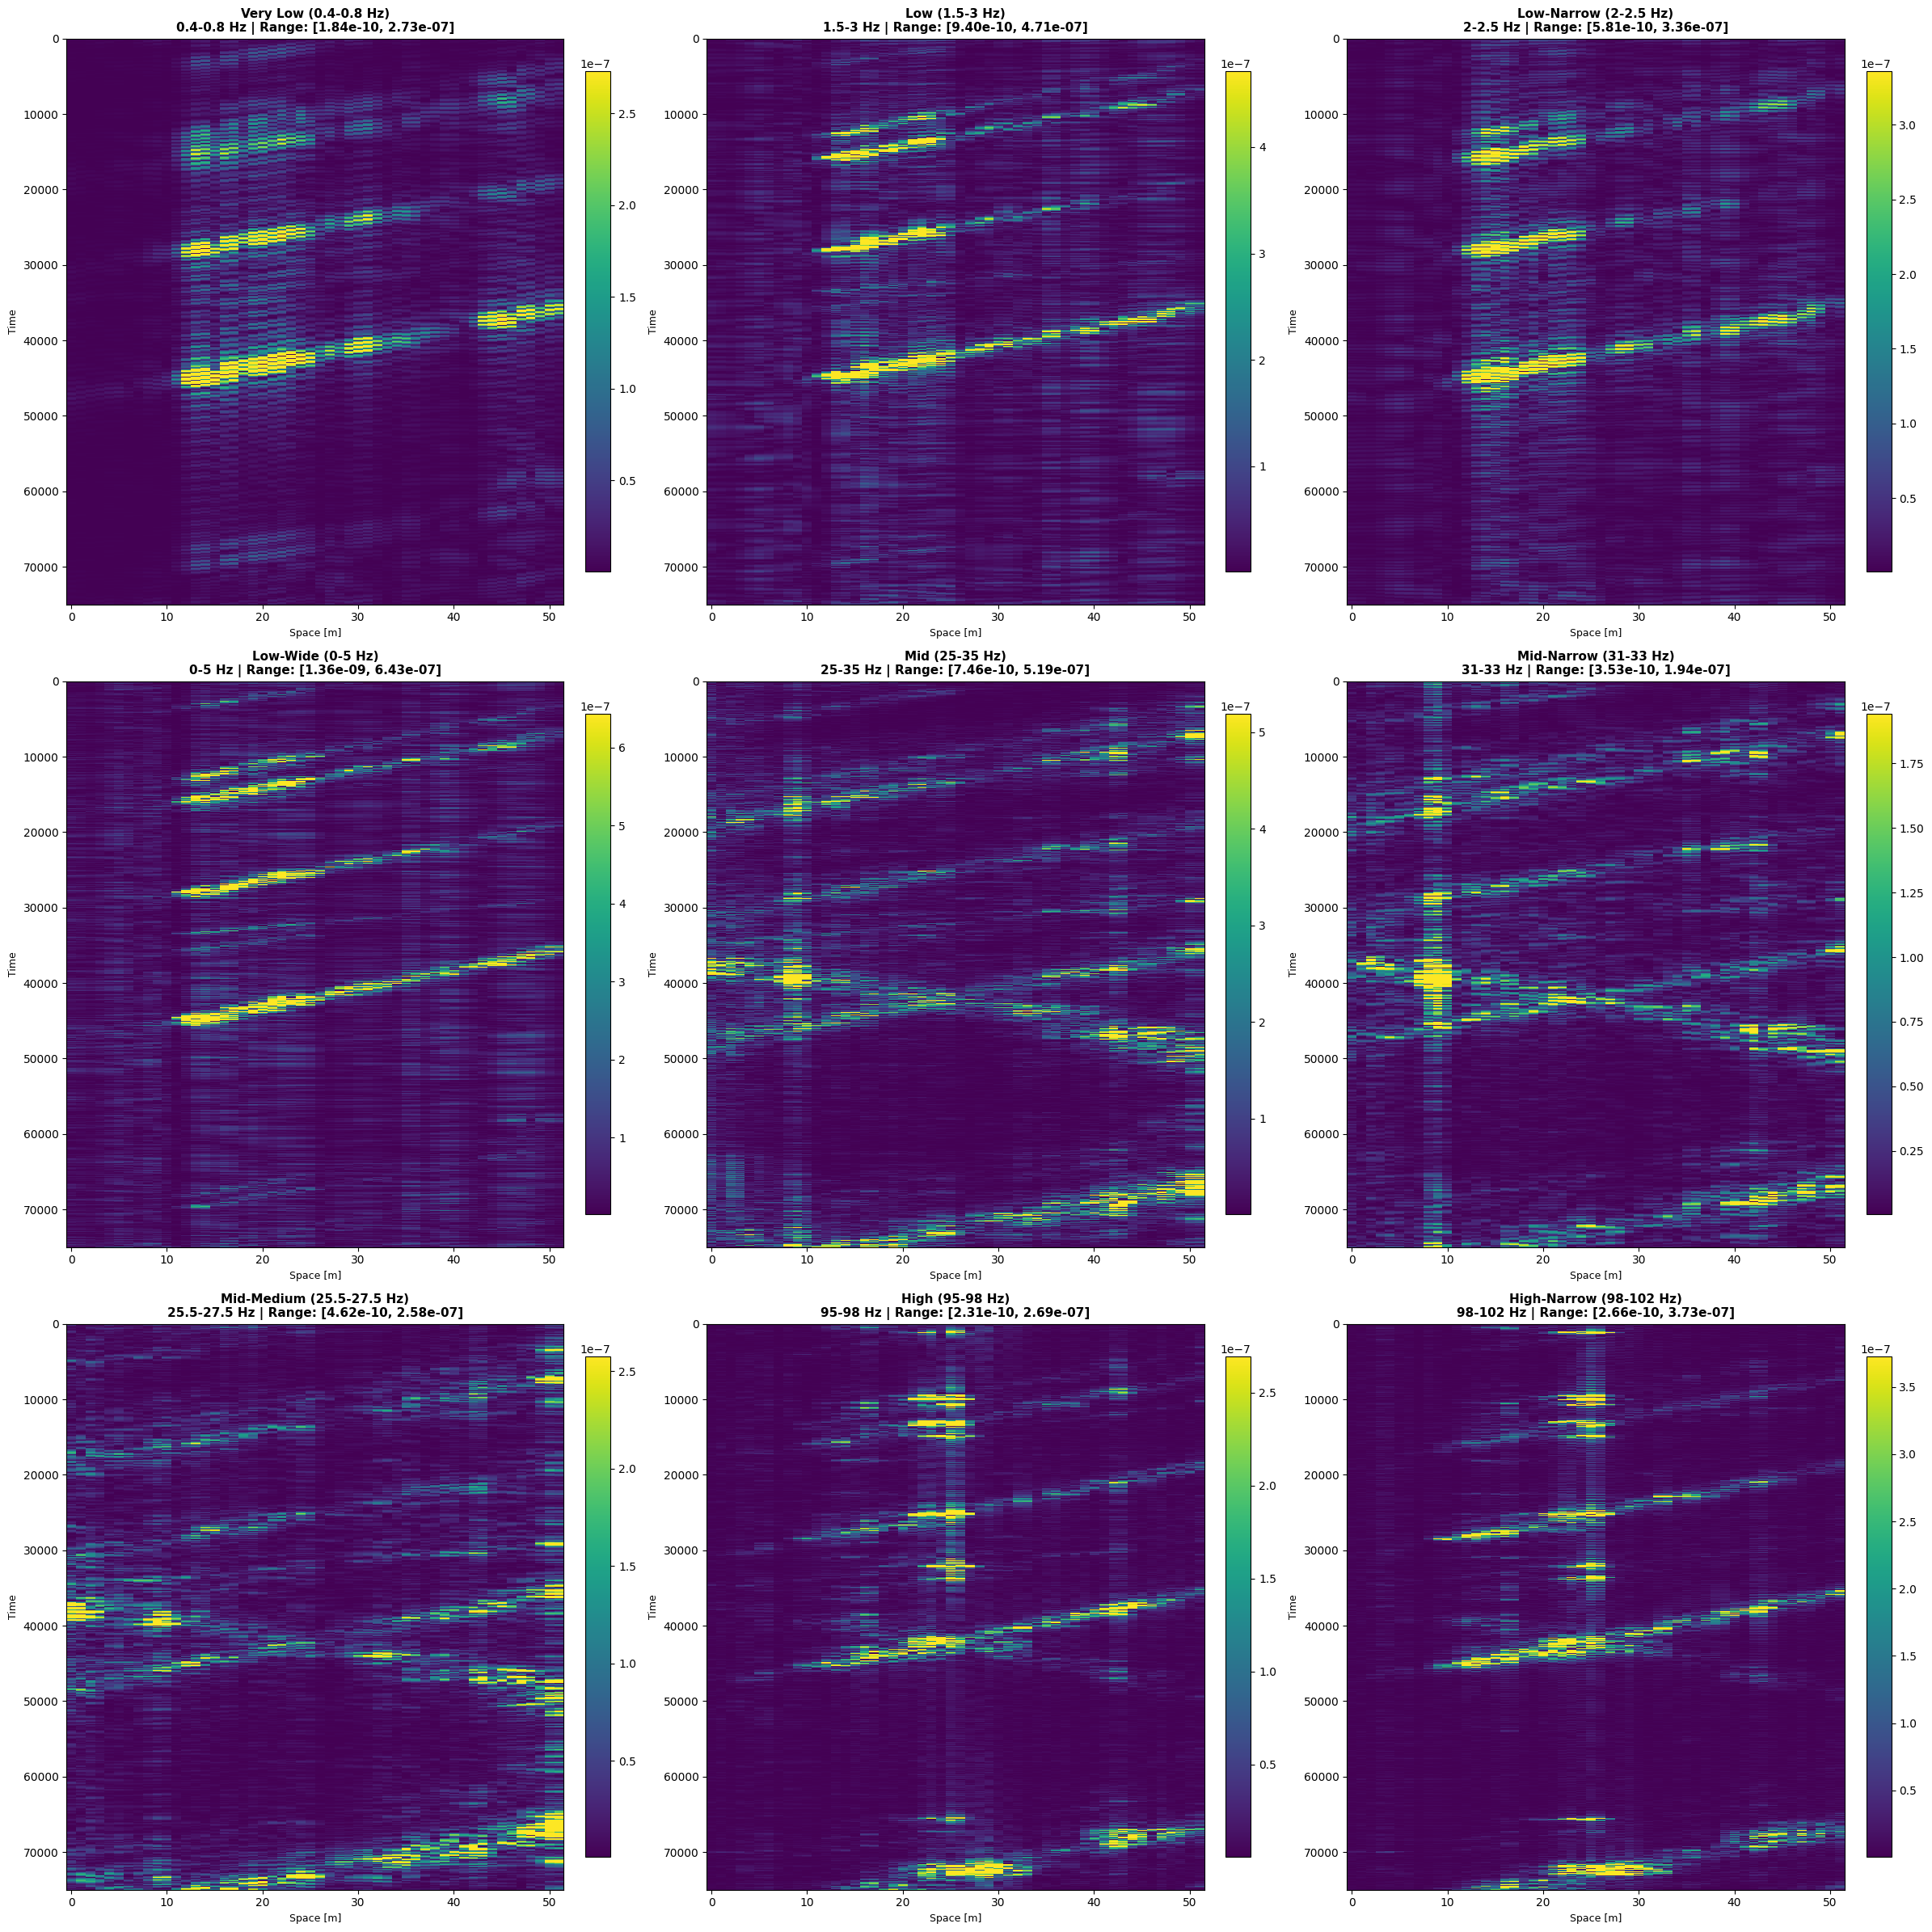

In [257]:
print("\n" + "="*70)
print("VERSION 1: Full Range Normalization")
print("="*70)
compare_filters_preprocessed(df_raw, use_percentile=False)

# Run comparison with percentile normalization
print("\n" + "="*70)
print("VERSION 2: Percentile Normalization (3-99%)")
print("="*70)
compare_filters_preprocessed(df_raw, use_percentile=True)

In [272]:
def squeeze_dataframe(df, axis, factor):
    """
    Squeeze DataFrame along specified axis using averaging.
    
    Parameters:
    - df: input DataFrame
    - axis: 0 for time (rows), 1 for space (columns)
    - factor: squeeze factor (< 1). e.g., 0.5 = squeeze to half size
    """
    if not 0 < factor < 1:
        raise ValueError("Squeeze factor must be between 0 and 1")
    
    int_factor = int(1 / factor)
    data = df.values
    
    if axis == 0:  # Time squeeze
        new_height = data.shape[0] // int_factor
        cropped = data[:new_height * int_factor]
        squeezed = cropped.reshape(new_height, int_factor, data.shape[1]).mean(axis=1)
        new_index = df.index[::int_factor][:new_height]
        new_columns = df.columns
    else:  # Space squeeze
        new_width = data.shape[1] // int_factor
        cropped = data[:, :new_width * int_factor]
        squeezed = cropped.reshape(data.shape[0], new_width, int_factor).mean(axis=2)
        new_index = df.index
        new_columns = df.columns[::int_factor][:new_width]
    
    return pd.DataFrame(squeezed, index=new_index, columns=new_columns)


def stretch_dataframe(df, axis, factor):
    """
    Stretch DataFrame along specified axis using repetition.
    
    Parameters:
    - df: input DataFrame
    - axis: 0 for time (rows), 1 for space (columns)
    - factor: stretch factor (> 1). Must be integer.
    """
    if factor <= 1:
        raise ValueError("Stretch factor must be > 1")
    
    int_factor = int(factor)
    stretched = np.repeat(df.values, int_factor, axis=axis)
    
    if axis == 0:  # Time stretch
        new_index = df.index.repeat(int_factor)
        new_columns = df.columns
    else:  # Space stretch
        new_index = df.index
        new_columns = df.columns.repeat(int_factor)
    
    return pd.DataFrame(stretched, index=new_index, columns=new_columns)


def resize_to_square(df, target_size=1000):
    """Resize DataFrame to square dimensions using squeeze/stretch."""
    print(f"\nResizing to {target_size}×{target_size}...")
    
    initial_rows = df.shape[0]
    initial_cols = df.shape[1]
    
    print(f"Initial shape: {initial_rows} × {initial_cols}")
    
    # Calculate factors
    squeeze_factor_time = target_size / initial_rows
    stretch_factor_space = int(target_size / initial_cols)
    
    print(f"Time squeeze factor: {squeeze_factor_time:.4f}")
    print(f"Space stretch factor: {stretch_factor_space}")
    
    # Apply transformations
    df_resized = squeeze_dataframe(df, axis=0, factor=squeeze_factor_time)
    df_resized = stretch_dataframe(df_resized, axis=1, factor=stretch_factor_space)
    
    print(f"Final shape: {df_resized.shape[0]} × {df_resized.shape[1]}")
    print("✓ Resizing complete")
    
    return df_resized


Resizing to 750×750...
Initial shape: 75000 × 52
Time squeeze factor: 0.0100
Space stretch factor: 14
Final shape: 750 × 728
✓ Resizing complete
Saved: ../output/resized_square_data.png


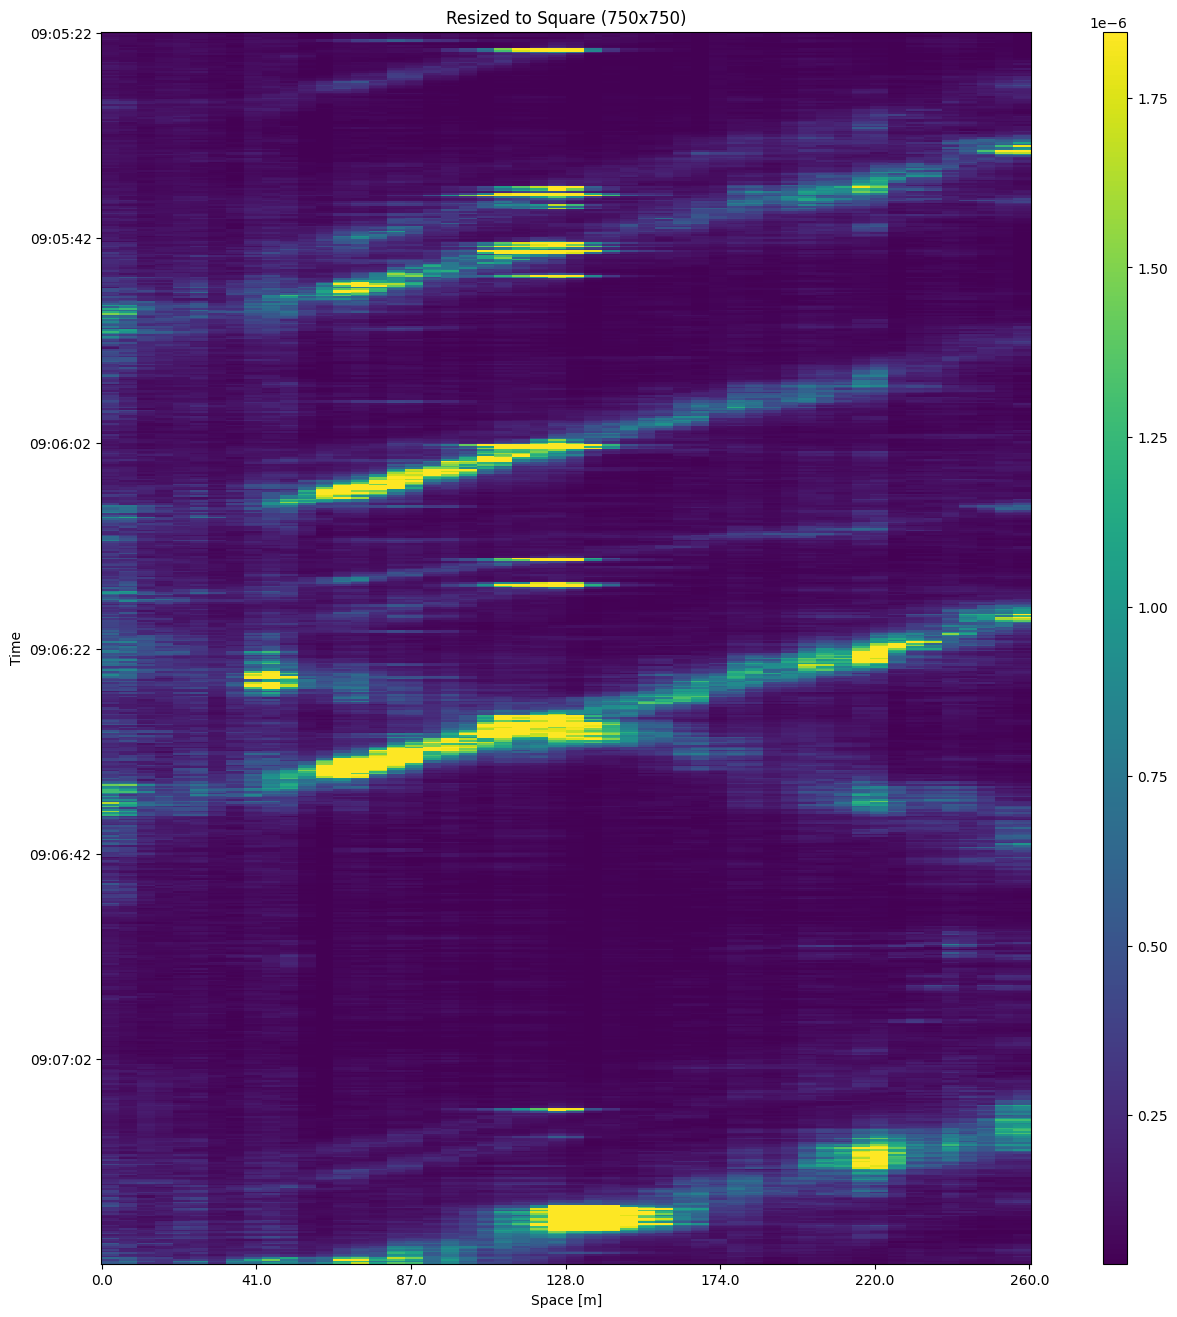

In [280]:
df_square = resize_to_square(df_abs, target_size=750)

# Visualize resized square data
visualize_das(df_square, title="Resized to Square (750x750)", 
              save_path=os.path.join(OUTPUT_PATH, 'resized_square_data.png'))

Threshold range: 3.12e-08 to 1.85e-06
Saved: ../output/thresholded_absolute_data.png


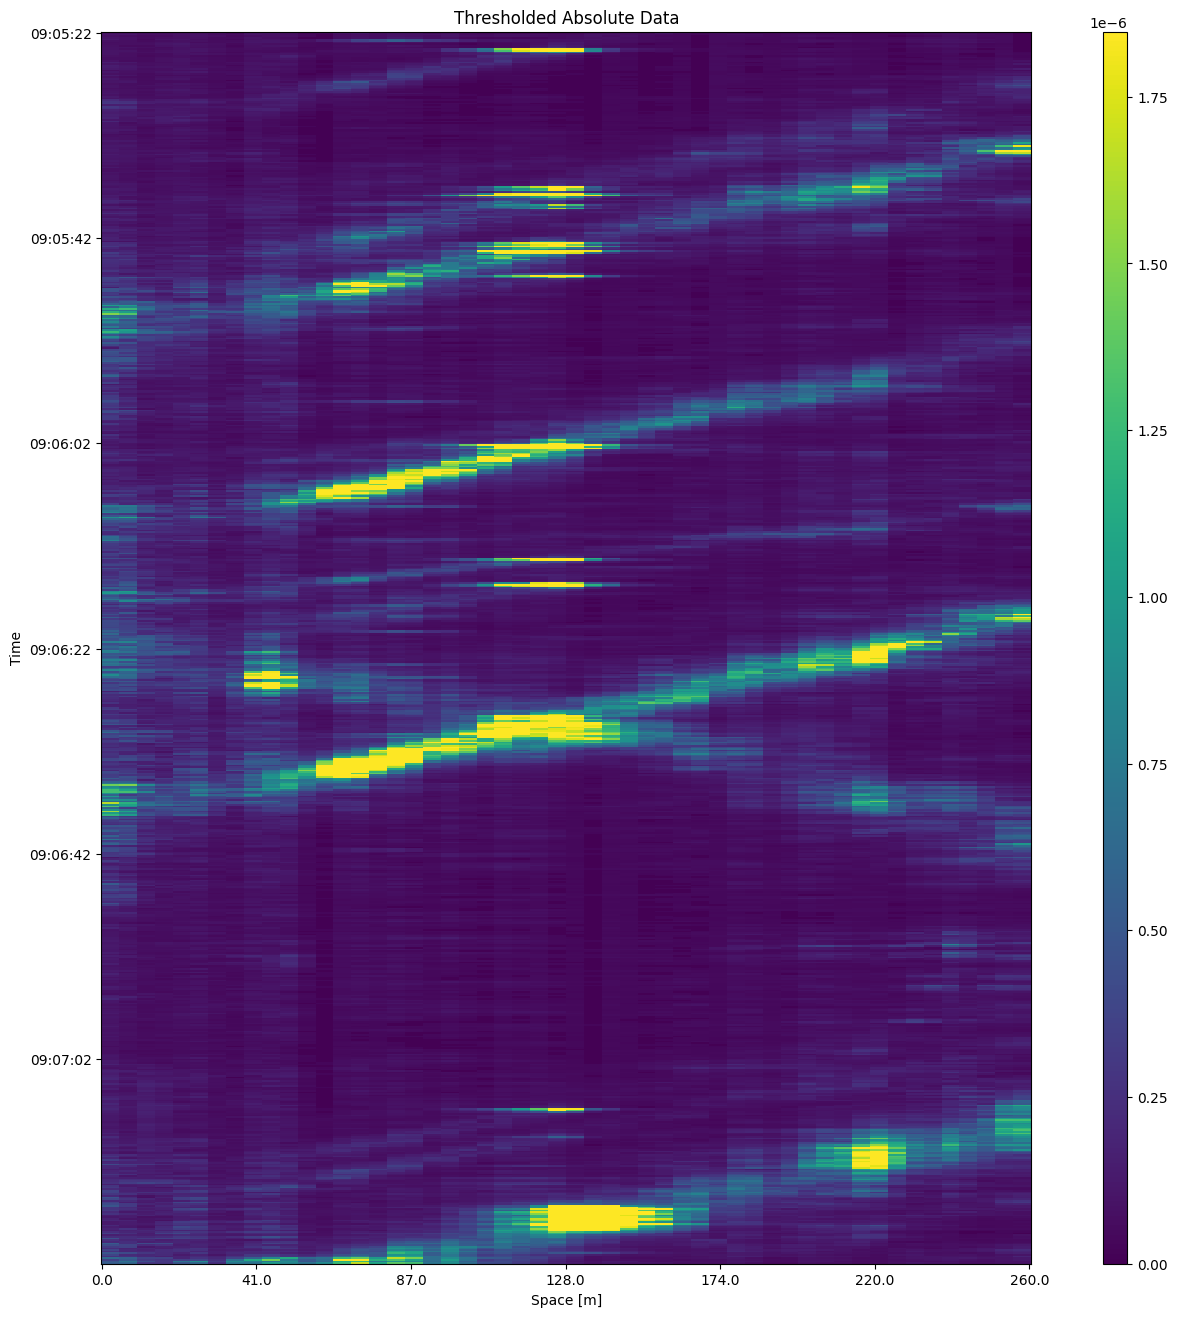

In [287]:
low_thresh = np.percentile(df_square, 3)
high_thresh = np.percentile(df_square, 99)

data_thresholded = df_square.copy()
data_thresholded[df_square < low_thresh] = 0
data_thresholded = np.clip(data_thresholded, 0, high_thresh)

print(f"Threshold range: {low_thresh:.2e} to {high_thresh:.2e}")

import pandas as pd
df_thresholded = pd.DataFrame(data=data_thresholded, index=df_square.index, columns=df_square.columns)
visualize_das(df_thresholded, title="Thresholded Absolute Data", 
              save_path=os.path.join(OUTPUT_PATH, 'thresholded_absolute_data.png'), normalize=False)

In [282]:
import numpy as np
import os
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

DX = 5.106500953873407
DT = 0.0016


def squeeze_image(img, axis, factor):
    """
    Squeeze image along specified axis using averaging for sharp results.
    
    Parameters:
    - img: input image
    - axis: 0 for vertical squeeze, 1 for horizontal squeeze
    - factor: squeeze factor (< 1). e.g., 0.5 = squeeze to half size
    
    Returns:
    - squeezed image
    """
    if factor >= 1:
        raise ValueError("Squeeze factor must be < 1")
    
    int_factor = int(1 / factor)
    
    if axis == 0:  # Vertical squeeze
        new_height = img.shape[0] // int_factor
        return img[:new_height * int_factor].reshape(new_height, int_factor, img.shape[1]).mean(axis=1)
    else:  # Horizontal squeeze
        new_width = img.shape[1] // int_factor
        return img[:, :new_width * int_factor].reshape(img.shape[0], new_width, int_factor).mean(axis=2)


def stretch_image(img, axis, factor):
    """
    Stretch image along specified axis using repetition for sharp results.
    
    Parameters:
    - img: input image
    - axis: 0 for vertical stretch, 1 for horizontal stretch
    - factor: stretch factor (> 1). e.g., 2.0 = stretch to double size
    
    Returns:
    - stretched image
    """
    if factor <= 1:
        raise ValueError("Stretch factor must be > 1")
    
    if factor == int(factor):
        return np.repeat(img, int(factor), axis=axis)
    

def extract_lines(image, threshold_ratio=0.85, sigma=1.0):
    """
    Extract lines from an image using Hough transform.
    
    Parameters:
    - image: input grayscale image (any range/dtype)
    - threshold_ratio: ratio of max hough space value to use as threshold
    - sigma: standard deviation for Canny edge detector
    
    Returns:
    - lines: list of tuples (angle, dist) for each detected line
    """
    # normalize to [0, 1] range
    image = (image - image.min()) / (image.max() - image.min())

    # Apply edge detection first
    edges = canny(image, sigma=sigma)
    
    # Now apply Hough transform on the binary edge image
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(edges, theta=tested_angles)
    
    # Extract peaks (detected lines)
    _, angles, dists = hough_line_peaks(h, theta, d, threshold=np.max(h) * threshold_ratio)
    
    # Return as list of (angle, distance) tuples
    lines = list(zip(angles, dists))
    
    return lines


def cluster_lines(lines, dx_effective, dt_effective, angle_threshold=np.radians(15), dist_threshold=45):    
    lines.sort(key=lambda x: x[0]) # sort by angle

    clusters = []
    used = set()

    for i, line1 in enumerate(lines):
        if i in used:
            continue
    
        # Start a new cluster with this line
        cluster = [line1]
        used.add(i)
    
        # Find all similar lines
        for j, line2 in enumerate(lines):
            if j in used or j <= i:
                continue
        
            angle1, dist1, velocity_kmh1, x1, y1 = line1
            angle2, dist2, velocity_kmh2, x2, y2 = line2
        
            # Check if angle and distance are within thresholds
            angle_diff = abs(angle1 - angle2)
            # Handle angle wrap-around at boundaries (-π/2 and π/2)
            # Lines at -π/2 and π/2 represent the same orientation
            if angle_diff > np.pi / 2:
                angle_diff = np.pi - angle_diff
        
            dist_diff = abs(dist1 - dist2)
        
            if angle_diff <= angle_threshold and dist_diff <= dist_threshold:
                cluster.append(line2)
                used.add(j)
    
        clusters.append(cluster)
    
    lines_clustered = []

    for cluster in clusters:
        if len(cluster) % 2 != 0: 
            middle_idx = int((len(cluster)-1)/2)
            middle_line = cluster[middle_idx]
            lines_clustered.append(middle_line)
        else:
            middle_line1 = cluster[len(cluster)//2-1]
            middle_line2 = cluster[len(cluster)//2]

            avg_angle = (middle_line1[0] + middle_line2[0]) / 2
            avg_dist = (middle_line1[1] + middle_line2[1]) / 2
            avg_x0, avg_y0 = avg_dist * np.array([np.cos(avg_angle), np.sin(avg_angle)])

            avg_slope_pixels = np.tan(avg_angle + np.pi / 2)
            avg_velocity_ms = abs(dx_effective / (dt_effective * avg_slope_pixels))
            avg_velocity_kmh = avg_velocity_ms * 3.6

            lines_clustered.append((avg_angle, avg_dist, avg_velocity_kmh, avg_x0, avg_y0))

    return lines_clustered


def process_lines(lines, dx_effective, dt_effective):
    lines_processed = []
    for angle, dist in lines:
        x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
        
        # slope in image coordinates = dy/dx (pixels)
        slope_pixels = np.tan(angle + np.pi / 2)
        
        # velocity = distance/time = dx_effective / (dt_effective * slope_pixels)
        velocity_ms = abs(dx_effective / (dt_effective * slope_pixels))  # m/s
        velocity_kmh = velocity_ms * 3.6  # Convert to km/h
        
        if velocity_kmh > 140 or velocity_kmh < 30:
            continue  # Skip unrealistic velocities
        lines_processed.append((angle, dist, velocity_kmh, x0, y0))
    return lines_processed


def show_lines_clustered(df, image, lines, vertical_factor, horizontal_factor, dx=DX, dt=DT, output_dir="."):
    """
    Display image with detected lines and velocity annotations.
    
    Parameters:
    - image: input image
    - lines: list of (angle, dist) tuples
    - vertical_factor: factor by which image was stretched/squeezed vertically (>1 = stretched, <1 = squeezed)
    - horizontal_factor: factor by which image was stretched/squeezed horizontally (>1 = stretched, <1 = squeezed)
    - dx: spatial resolution (meters per pixel) - horizontal, BEFORE any stretching/squeezing
    - dt: temporal resolution (seconds per pixel) - vertical, BEFORE any stretching/squeezing
    """
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    
    im = ax.imshow(image, cmap='viridis', aspect='auto', interpolation='none')

    # Adjust dx and dt based on stretching/squeezing factors
    dx_effective = dx / horizontal_factor
    dt_effective = dt / vertical_factor

    lines_processed = process_lines(lines, dx_effective, dt_effective)
    lines_clustered = cluster_lines(lines_processed, dx_effective, dt_effective, angle_threshold=np.radians(15), dist_threshold=45)

    for angle, dist, velocity_kmh, x0, y0 in lines_clustered:
        ax.axline((x0, y0), slope=np.tan(angle + np.pi / 2), color='red', linewidth=2)
        text_x = x0 + 20
        text_y = y0
        ax.text(text_x, text_y, f'v={velocity_kmh:.2f} km/h', 
                color='yellow', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)

    # Set up axes labels
    ax.set_ylabel('time')
    ax.set_xlabel('space [m]')
    ax.set_title('Lines Clustered')

    # X-axis: space in meters
    space_positions = np.linspace(0, image.shape[1], 6)  # 6 tick marks
    space_labels = space_positions * dx_effective
    ax.set_xticks(space_positions, np.round(space_labels, 1))

    # Y-axis: time labels scaled to match transformed image height
    time_array = np.array([t.strftime('%H:%M:%S') for t in df.index.time])
    y_positions, y_labels = set_axis(time_array)
    
    # Scale y_positions to match the actual image height
    y_positions_scaled = y_positions * (image.shape[0] / len(df))
    ax.set_yticks(y_positions_scaled, y_labels)

    # Add colorbar on the right
    cax = fig.add_axes([ax.get_position().x1 + 0.06,
                        ax.get_position().y0,
                        0.02,
                        ax.get_position().height])
    plt.colorbar(im, cax=cax)

    plt.tight_layout()

    save_path = os.path.join(output_dir, "lines_clustered.png")
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Saved: {save_path}")
    

def show_lines_not_clustered(df, image, lines, vertical_factor, horizontal_factor, dx=DX, dt=DT, output_dir="."):
    """
    Display image with detected lines and velocity annotations.
    
    Parameters:
    - image: input image
    - lines: list of (angle, dist) tuples
    - vertical_factor: factor by which image was stretched/squeezed vertically (>1 = stretched, <1 = squeezed)
    - horizontal_factor: factor by which image was stretched/squeezed horizontally (>1 = stretched, <1 = squeezed)
    - dx: spatial resolution (meters per pixel) - horizontal, BEFORE any stretching/squeezing
    - dt: temporal resolution (seconds per pixel) - vertical, BEFORE any stretching/squeezing
    """
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    
    im = ax.imshow(image, cmap='viridis', aspect='auto', interpolation='none')

    # Adjust dx and dt based on stretching/squeezing factors
    dx_effective = dx / horizontal_factor
    dt_effective = dt / vertical_factor

    lines_processed = process_lines(lines, dx_effective, dt_effective)

    for angle, dist, velocity_kmh, x0, y0 in lines_processed:
        ax.axline((x0, y0), slope=np.tan(angle + np.pi / 2), color='red', linewidth=2)
        text_x = x0 + 20
        text_y = y0
        ax.text(text_x, text_y, f'v={velocity_kmh:.2f} km/h', 
                color='yellow', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)

    # Set up axes labels
    ax.set_ylabel('time')
    ax.set_xlabel('space [m]')
    ax.set_title('Lines not clustered')

    # X-axis: space in meters
    space_positions = np.linspace(0, image.shape[1], 6)  # 6 tick marks
    space_labels = space_positions * dx_effective
    ax.set_xticks(space_positions, np.round(space_labels, 1))

    # Y-axis: time labels scaled to match transformed image height
    time_array = np.array([t.strftime('%H:%M:%S') for t in df.index.time])
    y_positions, y_labels = set_axis(time_array)
    
    # Scale y_positions to match the actual image height
    y_positions_scaled = y_positions * (image.shape[0] / len(df))
    ax.set_yticks(y_positions_scaled, y_labels)

    # Add colorbar on the right
    cax = fig.add_axes([ax.get_position().x1 + 0.06,
                        ax.get_position().y0,
                        0.02,
                        ax.get_position().height])
    plt.colorbar(im, cax=cax)

    plt.tight_layout()

    save_path = os.path.join(output_dir, "lines_not_clustered.png")
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Saved: {save_path}")


def detect_lines(df, image, vertical_factor, horizontal_factor, threshold_ratio=0.85, sigma=1.0, output_dir="."):
    """
    Wrapper to extract lines from an image and display them with velocities.
    
    Parameters:
    - image: input grayscale image
    - vertical_factor: factor by which image was stretched/squeezed vertically
    - horizontal_factor: factor by which image was stretched/squeezed horizontally
    - threshold_ratio: ratio of max hough space value to use as threshold
    - sigma: standard deviation for Canny edge detector
    """
    lines = extract_lines(image, threshold_ratio=threshold_ratio, sigma=sigma)

    show_lines_not_clustered(df, image, lines, vertical_factor, horizontal_factor, output_dir=output_dir)
    show_lines_clustered(df, image, lines, vertical_factor, horizontal_factor, output_dir=output_dir)

In [289]:
image = df_thresholded.values.copy()
detect_lines(
        df_thresholded,
        image, 
        vertical_factor=0.01, 
        horizontal_factor=10.0, 
        threshold_ratio=0.45, output_dir=OUTPUT_PATH
    )

Saved: ../output/lines_not_clustered.png
Saved: ../output/lines_clustered.png
